In [36]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import sympy as sp

data = pd.read_csv(r"E:\参加点比赛\数模研赛\data\能源消费量预测数据.csv")
print(data.columns.values)
system = data.copy()

['时间' '常驻人口总量' '区域生产总值' '能源消费量']


In [37]:
system

,时间,常驻人口总量,区域生产总值,能源消费量
0,2010,7869.34,41383.87000,23539.31443
1,2011,8022.99,45952.65000,26860.02581
2,2012,8119.81,50660.20000,27999.21811
3,2013,8192.44,55580.11000,28203.10427
4,2014,8281.09,60359.43000,28170.50576
5,2015,8315.11,65552.00000,29033.60807
6,2016,8381.47,70665.70683,29947.97662
7,2017,8423.50,75752.20149,30669.88646
8,2018,8446.19,80827.71193,31373.12665
9,2019,8469.09,85556.13387,32227.50539


### 多元线性回归得到 能源消费量与经济、人口关系

In [23]:
# 选择自变量与因变量
X = system.loc[:, ['区域生产总值', '常驻人口总量']].values
y = system['能源消费量'].values

# 创建线性回归模型
model = LinearRegression()

# 多元线性回归拟合模型
model.fit(X, y)

# 输出参数
coef = model.coef_
intercept = model.intercept_
R2 = model.score(X, y)
print("回归系数为: ", coef)
print("截距为: ", intercept)
print("模型R2为: ", R2)

回归系数为:  [ 0.02463048 10.15905667]
截距为:  -56613.85751984094
模型R2为:  0.93952462284207


### 拟合得到关于t的方程

In [24]:
# 对区域生产总值做拟合
x = system['时间'].values.tolist()
y = system['区域生产总值'].values.tolist()
# 关于x，y做线性回归
x = system['时间'].values.tolist()
y = system['区域生产总值'].values.tolist()
# 拟合出参数
def function_linear(x, a, b):
    return a*x + b
init = (1, 1)
params, convariance = curve_fit(function_linear, x, y, p0=init)
a, b = params
# 建立线性回归函数
x = sp.symbols('x')
predict_gdp = a*x + b

In [25]:
predict_gdp

4873.30594129267*x - 9754168.45090928

In [26]:
# 对常驻人口总量做拟合
x = system['时间'].values.tolist()
y = system['常驻人口总量'].values.tolist()

# 关于x，y做线性回归
x = system['时间'].values.tolist()
y = system['常驻人口总量'].values.tolist()
# 拟合出参数
def function_linear(x, a1, b1):
    return a1*x + b1
init = (1, 1)
params, convariance = curve_fit(function_linear, x, y, p0=init)
a1, b1 = params
# 建立线性回归函数
x = sp.symbols('x')
predict_linear = a1*x + b1

# 关于x，y做多项式函数回归
x = system['时间'].values.tolist()
y = system['常驻人口总量'].values.tolist()
# 拟合出参数
def function_poly(x, a, b, c):
    return a * x**2 + b * x + c
init = (1, 1, 1)
params, convariance = curve_fit(function_poly, x, y, p0=init)
a, b, c = params
# 建立多项式函数回归函数
x = sp.symbols('x')
predict_poly = a*(x**2) + b*x +c
predict_p = 0.8*predict_linear + 0.2*predict_poly

In [27]:
predict_p.subs(x, 2)

-5042879.30814663

### 预测经济、人口

In [34]:
predict_e = coef[0] * predict_gdp + coef[1] * predict_p + intercept
print(predict_gdp) 
print(predict_p) 
print(predict_e) 

system_pre = pd.DataFrame({'时间': [i for i in range(2010, 2061)]})
system_pre['区域生产总值预测值'] = 99
system_pre['常驻人口总量预测值'] = 99
system_pre['能源消费量预测值'] = 99

for i in range(system_pre.shape[0]):
    t = system_pre.loc[i, ['时间']].values[0] # 第i个时间点
    gdp_t = predict_gdp.subs(x, t) # 预测gdp
    p_t = predict_p.subs(x, t)
    e_t = predict_e.subs(x, t)
    system_pre.loc[i, ['区域生产总值预测值']] = gdp_t
    system_pre.loc[i, ['常驻人口总量预测值']] = p_t
    system_pre.loc[i, ['能源消费量预测值']] = e_t

4873.30594129267*x - 9754168.45090928
-1.21778554789334*x**2 + 4965.54521255419*x - 5052805.52742955
-12.3715523875346*x**2 + 50565.2870580482*x - 51628601.3893181


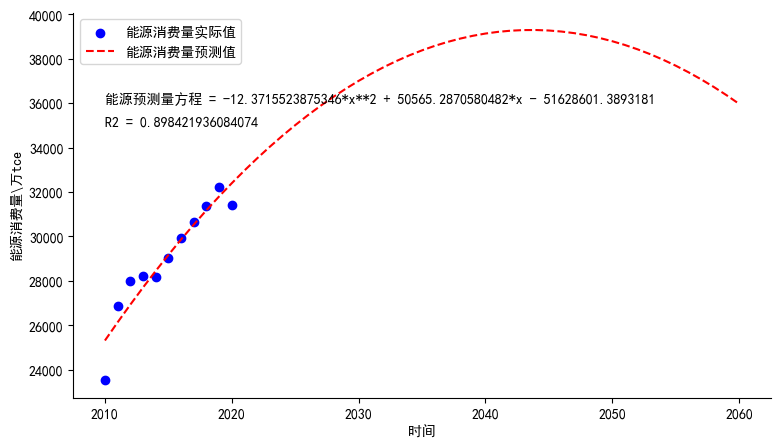

In [62]:
# 绘制原始曲线、两条拟合结果
import matplotlib.pyplot as plt
from pylab import * 
import seaborn as sns
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体（解决中文无法显示的问题）
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号“-”显示方块的问题
fig = plt.figure(figsize=(9, 5))
(ax) = fig.subplots(1, 1)

ax.scatter(system['时间'], system['能源消费量'], c='b', label='能源消费量实际值')
ax.plot(system_pre['时间'], system_pre['能源消费量预测值'], c='r', linestyle='--', label='能源消费量预测值')
ax.text(system_pre['时间'][0], 36000, "能源预测量方程 = {}".format(predict_e))
R2 = r2_score(system['能源消费量'].values[:11], 
         system_pre['能源消费量预测值'].values[:11])
ax.text(system['时间'][0], 35000, "R2 = {}".format(R2))
ax.spines['right'].set_color(None) 
ax.spines['top'].set_color(None) 
ax.legend()

ax.set_xlabel('时间')
ax.set_ylabel('能源消费量\万tce')

plt.savefig(r"E:\参加点比赛\数模研赛\results\T2\能源消费量预测图.jpg", dpi=500)
system_pre.to_csv(r"E:\参加点比赛\数模研赛\results\T2\能源消费量预测表.csv", encoding='utf-8-sig', index=False)